In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import keras.models as models
import keras.layers as layers
from keras.applications.efficientnet import EfficientNetB0

from data_processing import preprocess, visualize

In [2]:
# # reload modules after making changes
# import importlib
# importlib.reload(preprocess)
# importlib.reload(visualize)

In [3]:
# set constants
TRAINING_IMAGES_DIR = 'data/images/TRAIN' # directory/path to training images
TEST_IMAGES_DIR = 'data/images/TEST' # directory/path to test images
TRAINING_LABELS_PATH = 'data/labels.csv' # path to training labels csv

# image size (required by EfficientNet)
IMAGE_HEIGHT = 224 # pixels
IMAGE_WIDTH = 224 # pixels

# dictionaries mapping each label to an integer representation (or vice versa)
REP_TO_LABELS = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
LABELS_TO_REP = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

## Data Loading

As before, we load our data into tf.data.Dataset objects so that we can avoid issues with loading all of the images into memory. We pass in the target size to automatically resize our images.

In [4]:
# construct tf.data.Datasets to hold our data:
train_set, val_set = preprocess.load_images_dataset(TRAINING_IMAGES_DIR,
                                                     target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                     batch_size=10,
                                                     validation_split=0.2)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Using 1991 files for validation.


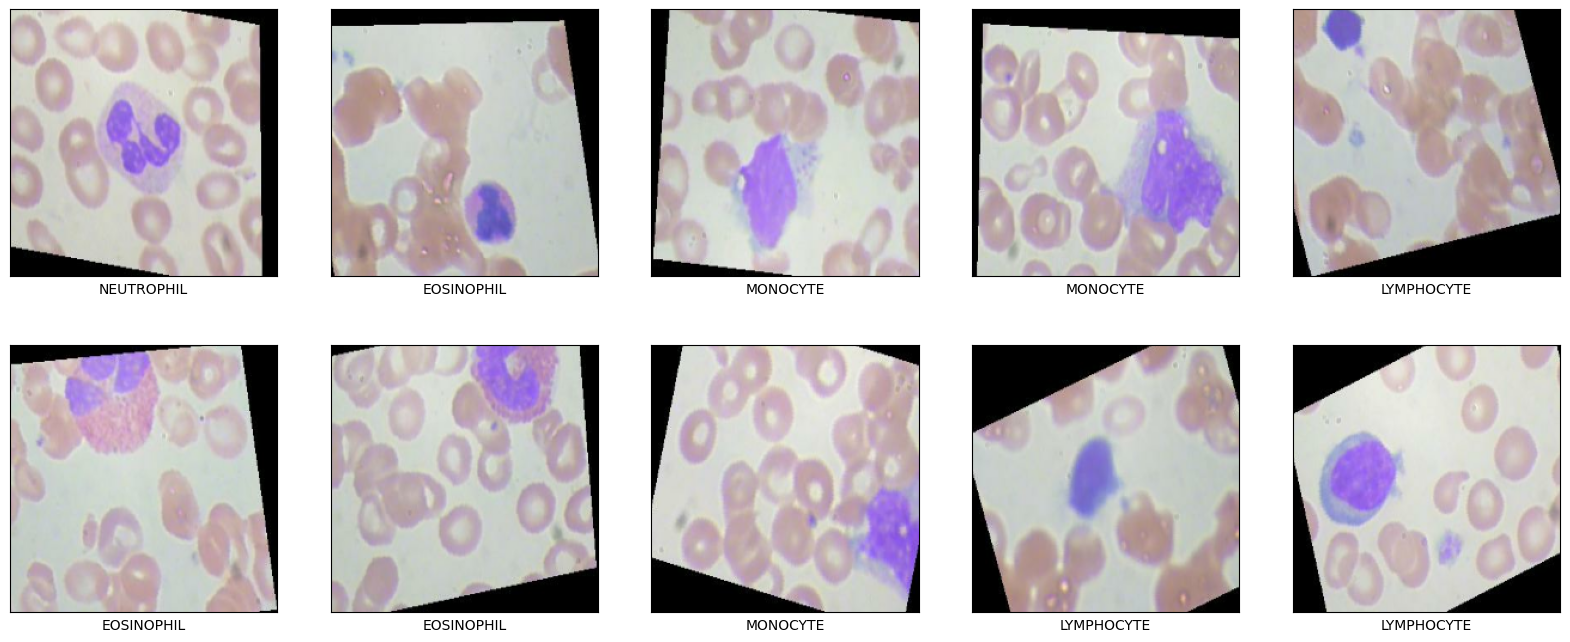

In [5]:
# visualize dataset
visualize.visualize_dataset(train_set, REP_TO_LABELS)

## Model 2: Transfer Learning with EfficientNet

In [6]:
# load EfficientNet 
enet = EfficientNetB0(include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
enet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

Tensorflow lets us download the EfficientNet architecture directly via `tf.keras.applications`. We load EfficientNet with its weights pretrained on ImageNet, but without the top prediction layers (that were trained for ImageNet) so that we can add our own. We freeze the layers originating from EfficientNet to train the new prediction layers. 
The input shape is predetermined by what EfficientNetB0 wants: images of shape (224,224,3).

In [7]:
# freeze efficientnet layers
for layer in enet.layers:
    layer.trainable = False

# add final prediction layers
model_enet_tl = models.Sequential([enet, 
                                   layers.GlobalAveragePooling2D(),
                                   layers.BatchNormalization(),
                                   layers.Dropout(0.2),
                                   layers.Dense(4)])

model_enet_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,059,815
Trainable params: 7,684
Non-trai

In [8]:
# stop early if loss stops improving
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# compile model
model_enet_tl.compile(optimizer='adam',
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# train prediction layers
history_enet_tl = model_enet_tl.fit(train_set,
                                    epochs=20,
                                    validation_data=val_set,
                                    callbacks=[early_stop])

Epoch 1/20
797/797 [==============================] - 34s 33ms/step - loss: 0.8596 - accuracy: 0.6521 - val_loss: 0.3586 - val_accuracy: 0.8709
Epoch 2/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5771 - accuracy: 0.7690 - val_loss: 0.2858 - val_accuracy: 0.8965
Epoch 3/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5255 - accuracy: 0.7920 - val_loss: 0.2559 - val_accuracy: 0.9081
Epoch 4/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5206 - accuracy: 0.7945 - val_loss: 0.2377 - val_accuracy: 0.9076
Epoch 5/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5210 - accuracy: 0.7979 - val_loss: 0.2217 - val_accuracy: 0.9141
Epoch 6/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5091 - accuracy: 0.8071 - val_loss: 0.2221 - val_accuracy: 0.9166
Epoch 7/20
797/797 [==============================] - 24s 30ms/step - loss: 0.4933 - accuracy: 0.8131 - val_loss: 0.2161 - val_accuracy:

We implemented EarlyStopping with 20 epochs to ensure that the model was fully trained and to prevent overfitting.

Here is a plot of the training history.

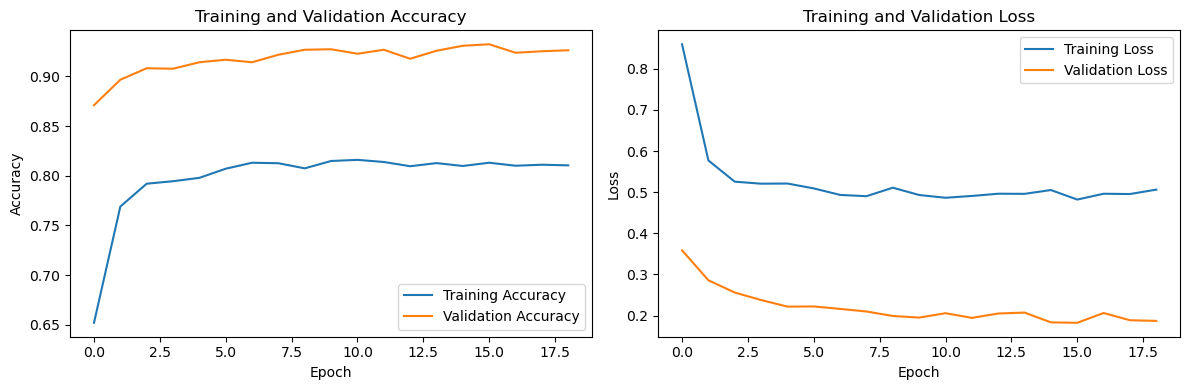

In [9]:
visualize.visualize_history(history_enet_tl)

It is a lot more stable than our previous model!

Next, we fine tune some of the EfficientNet weights to see if we can get better accuracy.

In [10]:
# fine tuning:

# unfreeze top twenty layers except batchnormalization
for layer in model_enet_tl.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

# recompile model
model_enet_tl.compile(optimizer=keras.optimizers.Adam(1e-5),
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# train
history_enet_tuned = model_enet_tl.fit(train_set,
                                       epochs=4,
                                       validation_data=val_set)

Epoch 1/4
797/797 [==============================] - 83s 91ms/step - loss: 1.6735 - accuracy: 0.5402 - val_loss: 0.5329 - val_accuracy: 0.8081
Epoch 2/4
797/797 [==============================] - 71s 89ms/step - loss: 0.7507 - accuracy: 0.7561 - val_loss: 0.2327 - val_accuracy: 0.9086
Epoch 3/4
797/797 [==============================] - 71s 89ms/step - loss: 0.4847 - accuracy: 0.8371 - val_loss: 0.1316 - val_accuracy: 0.9488
Epoch 4/4
797/797 [==============================] - 71s 89ms/step - loss: 0.3165 - accuracy: 0.8885 - val_loss: 0.0883 - val_accuracy: 0.9689


We unfreeze the top 20 layers (the ones nearest the output layers) except for BatchNormalization layers because retraining BatchNormalization could destroy what EfficientNet has learned. We compile and train the model with low learning rate and few epochs because we did not want the EfficientNet weights to be destroyed.

Here is the history for the fine-tuning process:

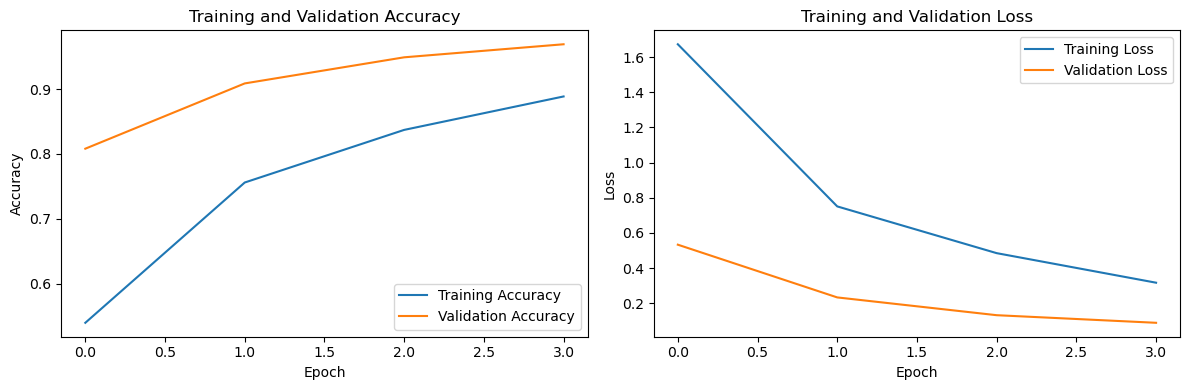

In [11]:
visualize.visualize_history(history_enet_tuned)

In [12]:
# # save weights
# model_enet_tl.save_weights("bloodcell-efficientnetb0_weights.h5")

We check our test accuracy and loss, and visualize some examples to compare true and predicted labels, and show prediction probability:

In [13]:
# load test set
test_set = preprocess.load_images_dataset(TEST_IMAGES_DIR,
                                          target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size=1)

# evaluate the model on the test set
test_loss, test_accuracy = model_enet_tl.evaluate(test_set)

print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

Found 2487 files belonging to 4 classes.
2487/2487 [==============================] - 30s 12ms/step - loss: 0.7711 - accuracy: 0.8456
Test accuracy: 0.8455970883369446
Test loss: 0.7710707187652588


1/1 [==============================] - 2s 2s/step


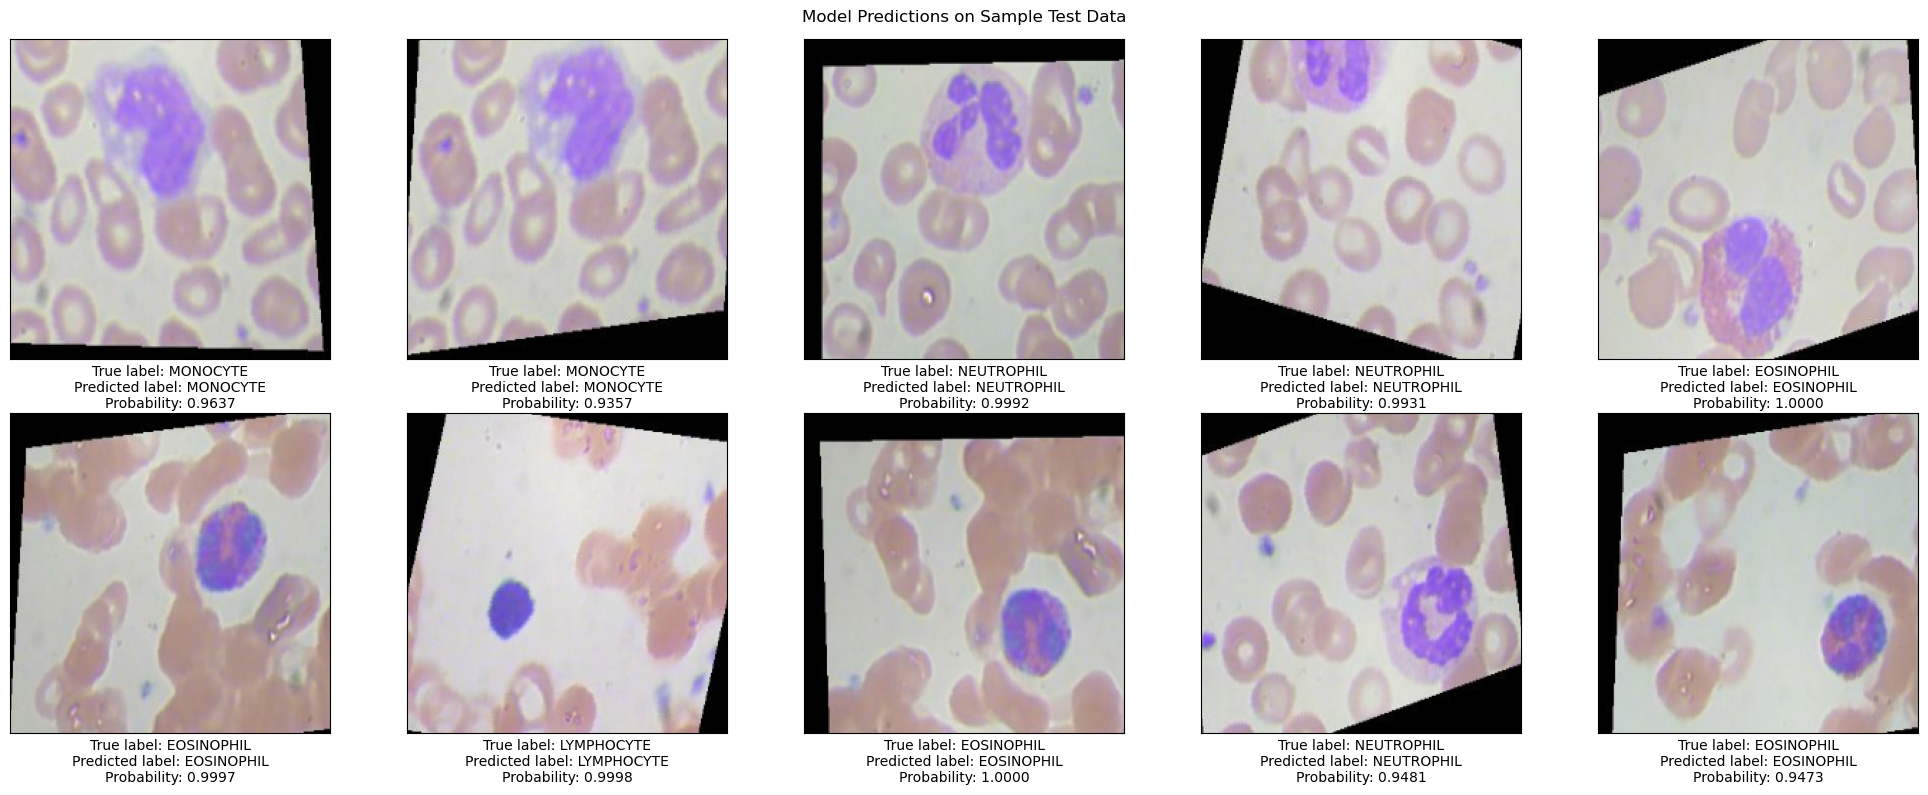

In [14]:
visualize.visualize_predictions(model_enet_tl, REP_TO_LABELS, test_dataset=test_set)

Let's take a look at the confusion matrix:

              precision    recall  f1-score   support

  EOSINOPHIL       0.87      0.78      0.82       623
  LYMPHOCYTE       0.98      0.97      0.98       620
    MONOCYTE       0.96      0.73      0.83       620
  NEUTROPHIL       0.67      0.90      0.77       624

    accuracy                           0.85      2487
   macro avg       0.87      0.85      0.85      2487
weighted avg       0.87      0.85      0.85      2487



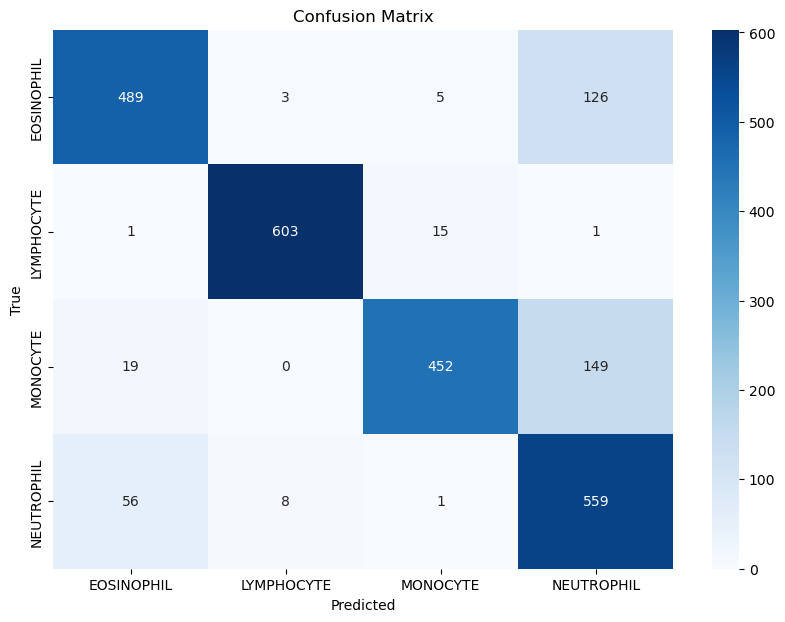

In [15]:
# show confusion matrix
visualize.visualize_conf_matrix(model_enet_tl, test_set, REP_TO_LABELS)

We see that the new transfer learning model does very well overall, but it still confuses some of the more similar blood cells. It especially confuses
many cells with neutrophils.

In comparison to our first two models, it outperforms fairly significantly. It was much stabler when training, so we could be sure that early stopping
stopped training when our model was fully trained.